# Tweet Sentiment Analysis

## Table of Contents

- [Import Libraries](#import)

<a id = 'import'></a>
# Import Libraries

In [16]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import re, string, unicodedata
from sklearn.metrics import accuracy_score
from pandas import DataFrame
from nltk import word_tokenize, sent_tokenize
from nltk.stem import LancasterStemmer, WordNetLemmatizer
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from wordcloud import WordCloud
nltk.download('stopwords')

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv


In [6]:
cols = ['sentiment','id','date','query_string','user','text']
data = pd.read_csv("/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv",engine='python',header=None, names=cols)
data.head()

,sentiment,id,date,query_string,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


<a id = "data"></a>
# Data Cleaning

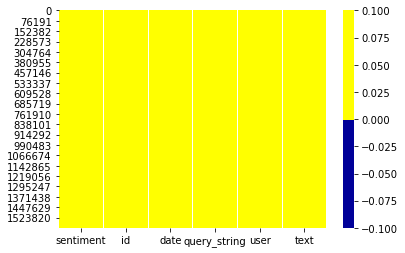

In [9]:
colours = ['#000099', '#ffff00'] # specify the colours - yellow is missing. blue is not missing.
sns.heatmap(data[cols].isnull(), cmap=sns.color_palette(colours))

In [14]:
def remove_URL(sample):
    return re.sub(r"http\S+", "", sample)

def remove_non_ascii(words):
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def to_lowercase(words):
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

def remove_punctuation(words):
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def remove_stopwords(words):
    new_words = []
    for word in words:
        if word not in stopwords.words('english'):
            new_words.append(word)
    return new_words

def stem_words(words):
    stemmer = LancasterStemmer()
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems

def lemmatize_verbs(words):
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

def normalize(words):
    words = remove_non_ascii(words)
    words = to_lowercase(words)
    words = remove_punctuation(words)
    words = remove_stopwords(words)
    return words

def preprocess(sample):
    sample = remove_URL(sample)
    words = nltk.word_tokenize(sample)

    # Normalize
    return normalize(words)

In [17]:
length = round(len(data))
vocabulary = []
train = []
test = []
for x in range(length):
    text = data['text'][x]
    new_text = preprocess(text)
    vocabulary.append(new_text)
    if x < length/2:
        train.append(' '.join(new_text))
    else:  
        test.append(' '.join(new_text))

KeyboardInterrupt: 

In [18]:
train = DataFrame(train,columns=['text'])
test = DataFrame(test, columns = ['text'])
y_test = []
for x in range(length):
    if x < length/2:
        train['id'] = data['id'][x]
        train['target'] = data['sentiment']
    else:
        test['id'] = data['id'][x]
        y_test.append(' '.join(data['sentiment'][x]))

KeyboardInterrupt: 

In [ ]:
train.head()

In [ ]:
test.head()

<a id = 'visual'></a>
# Visualizations

In [ ]:
tokens = [item for sublist in vocabulary for item in sublist]
print(len(tokens))
frequency_dist = nltk.FreqDist(tokens)
sorted(frequency_dist,key=frequency_dist.__getitem__, reverse=True)[0:50]

In [ ]:
wordcloud = WordCloud().generate_from_frequencies(frequency_dist)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

<a id = 'analysis'></a>
# Analysis

In [ ]:
X_train = train.loc[:-1, 'text'].values
y_train = train.loc[:-1, 'target'].values
X_test = test.loc[:-1, 'text'].values

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
train_vectors = vectorizer.fit_transform(X_train)
test_vectors = vectorizer.transform(X_test)
print(train_vectors.shape, test_vectors.shape)

In [ ]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(train_vectors, y_train)

In [ ]:
predicted = clf.predict(test_vectors)
final_accuracy = accuracy_score(predicted, y_train)
print('Accuracy: ', final_accuracy)

In [ ]:
output = pd.DataFrame({'id': test.id, 'target': predicted})
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")